In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install laspy
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 3.5 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 74.1 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.8
    Uninstalling widgetsnbextension-3.6.8:
      Successfully uninstalled widgetsnbextension-3.6.8
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 1048575 points.
Point cloud created.
Cleaned point cloud has 1035536 points.
Normals estimated.
Voxel grid created.


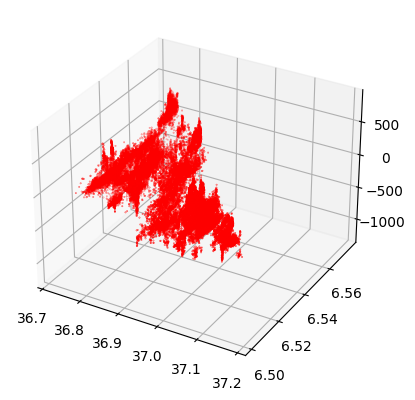

Voxel grid saved as 'voxel_grid_xyz.csv'.


In [3]:
import pandas as pd
import numpy as np
import open3d as o3d
from google.colab import drive

# Mount Google Drive to save files
drive.mount('/content/drive')

# 1. Load the XYZ data
df = pd.read_csv('/content/drive/MyDrive/Landslide/Beforepoints.csv')  # Replace with your file path
if not {'X', 'Y', 'Z'}.issubset(df.columns):
    raise ValueError("CSV file must contain 'X', 'Y', and 'Z' columns.")
points = df[['X', 'Y', 'Z']].to_numpy()
print(f"Loaded {points.shape[0]} points.")

# 2. Create Point Cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.paint_uniform_color([1.0, 1.0, 1.0])
print("Point cloud created.")

# 3. Optional Processing: Removing Outliers
cl, ind = pcd.remove_statistical_outlier(nb_neighbors=50, std_ratio=0.5)
clean_pcd = pcd.select_by_index(ind)
print(f"Cleaned point cloud has {len(clean_pcd.points)} points.")

# 4. Estimate Normals
clean_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=1.0, max_nn=30))
print("Normals estimated.")

# 5. Voxel Grid Computation
voxel_size = 0.1
nb_vox = np.ceil((np.max(points, axis=0) - np.min(points, axis=0)) / voxel_size).astype(int)

non_empty_voxel_keys, inverse, nb_pts_per_voxel = np.unique(
    ((points - np.min(points, axis=0)) // voxel_size).astype(int),
    axis=0,
    return_inverse=True,
    return_counts=True
)

idx_pts_vox_sorted = np.argsort(inverse)

voxel_grid = {}
grid_barycenter, grid_candidate_center = [], []
last_seen = 0

for idx, vox in enumerate(non_empty_voxel_keys):
    voxel_grid[tuple(vox)] = points[idx_pts_vox_sorted[last_seen:last_seen + nb_pts_per_voxel[idx]]]
    grid_barycenter.append(np.mean(voxel_grid[tuple(vox)], axis=0))
    grid_candidate_center.append(
        voxel_grid[tuple(vox)][np.linalg.norm(
            voxel_grid[tuple(vox)] - np.mean(voxel_grid[tuple(vox)], axis=0), axis=1
        ).argmin()]
    )
    last_seen += nb_pts_per_voxel[idx]

grid_barycenter = np.array(grid_barycenter)
grid_candidate_center = np.array(grid_candidate_center)
print("Voxel grid created.")

# 6. Visualization of the Voxel Grid
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(grid_candidate_center[:, 0], grid_candidate_center[:, 1], grid_candidate_center[:, 2], c='r', s=0.1)
plt.show()

# 7. Save Voxel Grid Results
output_path = '/content/drive/My Drive/'
np.savetxt(output_path + "voxel_grid_xyz.csv", grid_candidate_center, delimiter=",", header="X,Y,Z", comments='')
print("Voxel grid saved as 'voxel_grid_xyz.csv'.")


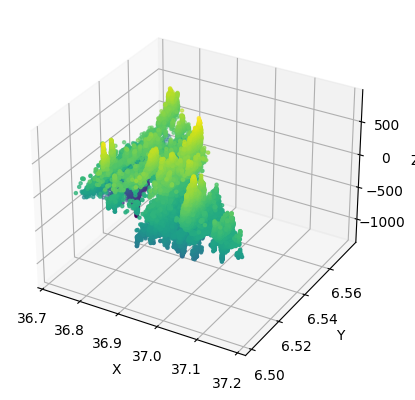

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Plotting with increased point size and a color map
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Use a color map and increase point size for better visibility
ax.scatter(grid_candidate_center[:, 0], grid_candidate_center[:, 1], grid_candidate_center[:, 2],
           c=grid_candidate_center[:, 2], cmap='viridis', s=5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 1048575 points.
Point cloud created.
Cleaned point cloud has 1035536 points.
Normals estimated.
Voxel grid created.


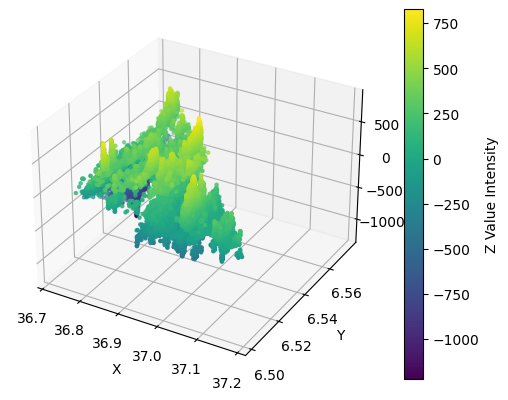

Voxel grid saved as 'voxel_grid_xyz.csv'.


In [5]:
import pandas as pd
import numpy as np
import open3d as o3d
from google.colab import drive

# Step 1: Mount Google Drive to Save Files
drive.mount('/content/drive')

# Step 2: Load the XYZ Data
df = pd.read_csv('/content/drive/MyDrive/Landslide/Beforepoints.csv')  # Replace with your file path
if not {'X', 'Y', 'Z'}.issubset(df.columns):
    raise ValueError("CSV file must contain 'X', 'Y', and 'Z' columns.")
points = df[['X', 'Y', 'Z']].to_numpy()
print(f"Loaded {points.shape[0]} points.")

# Step 3: Create Point Cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.paint_uniform_color([1.0, 1.0, 1.0])  # Optional: Color the point cloud uniformly
print("Point cloud created.")

# Step 4: Optional Processing - Removing Outliers
cl, ind = pcd.remove_statistical_outlier(nb_neighbors=50, std_ratio=0.5)
clean_pcd = pcd.select_by_index(ind)
print(f"Cleaned point cloud has {len(clean_pcd.points)} points.")

# Step 5: Estimate Normals
clean_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=1.0, max_nn=30))
print("Normals estimated.")

# Step 6: Voxel Grid Computation
voxel_size = 0.1  # Define the voxel size
nb_vox = np.ceil((np.max(points, axis=0) - np.min(points, axis=0)) / voxel_size).astype(int)

non_empty_voxel_keys, inverse, nb_pts_per_voxel = np.unique(
    ((points - np.min(points, axis=0)) // voxel_size).astype(int),
    axis=0,
    return_inverse=True,
    return_counts=True
)

idx_pts_vox_sorted = np.argsort(inverse)

voxel_grid = {}
grid_barycenter, grid_candidate_center = [], []
last_seen = 0

for idx, vox in enumerate(non_empty_voxel_keys):
    voxel_grid[tuple(vox)] = points[idx_pts_vox_sorted[last_seen:last_seen + nb_pts_per_voxel[idx]]]
    grid_barycenter.append(np.mean(voxel_grid[tuple(vox)], axis=0))
    grid_candidate_center.append(
        voxel_grid[tuple(vox)][np.linalg.norm(
            voxel_grid[tuple(vox)] - np.mean(voxel_grid[tuple(vox)], axis=0), axis=1
        ).argmin()]
    )
    last_seen += nb_pts_per_voxel[idx]

grid_barycenter = np.array(grid_barycenter)
grid_candidate_center = np.array(grid_candidate_center)
print("Voxel grid created.")

# Step 7: Visualization of the Voxel Grid
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(grid_candidate_center[:, 0], grid_candidate_center[:, 1], grid_candidate_center[:, 2],
           c=grid_candidate_center[:, 2], cmap='viridis', s=5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Adding a color bar to represent Z values
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label('Z Value Intensity')

plt.show()

# Step 8: Save Voxel Grid Results to Google Drive
output_path = '/content/drive/My Drive/'
np.savetxt(output_path + "voxel_grid_xyz.csv", grid_candidate_center, delimiter=",", header="X,Y,Z", comments='')
print("Voxel grid saved as 'voxel_grid_xyz.csv'.")


For after

In [6]:
df_after = pd.read_csv('/content/drive/MyDrive/Landslide/After_Finalcsv.csv')  # Replace with your file path
if not {'X', 'Y', 'Z'}.issubset(df_after.columns):
    raise ValueError("CSV file must contain 'X', 'Y', and 'Z' columns.")
points_after = df_after[['X', 'Y', 'Z']].to_numpy()
print(f"Loaded {points_after.shape[0]} points from the After data.")


Loaded 1048575 points from the After data.


In [7]:
pcd_after = o3d.geometry.PointCloud()
pcd_after.points = o3d.utility.Vector3dVector(points_after)
pcd_after.paint_uniform_color([1.0, 0.0, 0.0])  # Color the point cloud red for distinction
print("Point cloud for After data created.")

Point cloud for After data created.


In [15]:
cl_after, ind_after = pcd_after.remove_statistical_outlier(nb_neighbors=50, std_ratio=0.5)
clean_pcd_after = pcd_after.select_by_index(ind_after)
print(f"Cleaned point cloud for After data has {len(clean_pcd_after.points)} points.")


Cleaned point cloud for After data has 1039261 points.


In [16]:
clean_pcd_after.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=1.0, max_nn=30))
print("Normals estimated for After data.")

Normals estimated for After data.


In [17]:
voxel_size = 0.1  # Keep the voxel size consistent for comparison
nb_vox_after = np.ceil((np.max(points_after, axis=0) - np.min(points_after, axis=0)) / voxel_size).astype(int)

non_empty_voxel_keys_after, inverse_after, nb_pts_per_voxel_after = np.unique(
    ((points_after - np.min(points_after, axis=0)) // voxel_size).astype(int),
    axis=0,
    return_inverse=True,
    return_counts=True
)

idx_pts_vox_sorted_after = np.argsort(inverse_after)

voxel_grid_after = {}
grid_barycenter_after, grid_candidate_center_after = [], []
last_seen_after = 0

for idx, vox in enumerate(non_empty_voxel_keys_after):
    voxel_grid_after[tuple(vox)] = points_after[idx_pts_vox_sorted_after[last_seen_after:last_seen_after + nb_pts_per_voxel_after[idx]]]
    grid_barycenter_after.append(np.mean(voxel_grid_after[tuple(vox)], axis=0))
    grid_candidate_center_after.append(
        voxel_grid_after[tuple(vox)][np.linalg.norm(
            voxel_grid_after[tuple(vox)] - np.mean(voxel_grid_after[tuple(vox)], axis=0), axis=1
        ).argmin()]
    )
    last_seen_after += nb_pts_per_voxel_after[idx]

grid_barycenter_after = np.array(grid_barycenter_after)
grid_candidate_center_after = np.array(grid_candidate_center_after)
print("Voxel grid for After data created.")


Voxel grid for After data created.


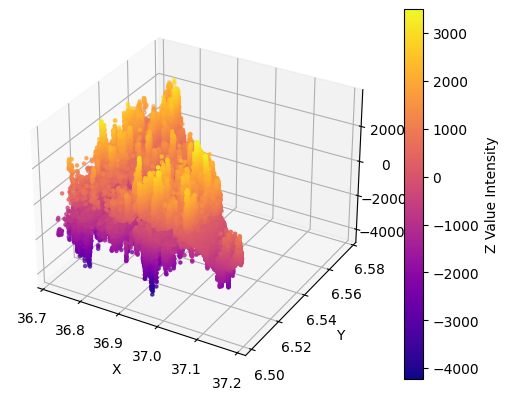

In [18]:
fig_after = plt.figure()
ax_after = fig_after.add_subplot(111, projection='3d')
ax_after.scatter(grid_candidate_center_after[:, 0], grid_candidate_center_after[:, 1], grid_candidate_center_after[:, 2],
            c=grid_candidate_center_after[:, 2], cmap='plasma', s=5)
ax_after.set_xlabel('X')
ax_after.set_ylabel('Y')
ax_after.set_zlabel('Z')

# Adding a color bar to represent Z values
cbar_after = plt.colorbar(ax_after.collections[0], ax=ax_after)
cbar_after.set_label('Z Value Intensity')

plt.show()

In [19]:
np.savetxt(output_path + "voxel_grid_xyz_after.csv", grid_candidate_center_after, delimiter=",", header="X,Y,Z", comments='')
print("Voxel grid for After data saved as 'voxel_grid_xyz_after.csv'.")


Voxel grid for After data saved as 'voxel_grid_xyz_after.csv'.


Deep kernel

In [22]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Example dimensions (Update these values based on your actual data)
D, H, W = 32, 32, 32  # Example dimensions, adjust accordingly

# Create sample data (Replace with actual voxel grid data)
voxel_grid_before = np.random.rand(D, H, W).astype(np.float32)
voxel_grid_after = np.random.rand(D, H, W).astype(np.float32)

# Convert to tensors and add batch and channel dimensions
voxel_grid_before_tensor = torch.tensor(voxel_grid_before).unsqueeze(0).unsqueeze(0)
voxel_grid_after_tensor = torch.tensor(voxel_grid_after).unsqueeze(0).unsqueeze(0)

# Creating datasets and dataloaders
dataset_before = TensorDataset(voxel_grid_before_tensor)
dataloader_before = DataLoader(dataset_before, batch_size=1, shuffle=True)

dataset_after = TensorDataset(voxel_grid_after_tensor)
dataloader_after = DataLoader(dataset_after, batch_size=1, shuffle=True)

# Define the Deep Kalman Filter model
class DeepKalmanFilter(nn.Module):
    def __init__(self, input_dim, latent_dim, obs_dim):
        super(DeepKalmanFilter, self).__init__()
        self.latent_dim = latent_dim
        self.obs_dim = obs_dim

        # Initial state distribution
        self.init_hidden = nn.Linear(input_dim, latent_dim)

        # Transition model
        self.trans_hidden = nn.Linear(latent_dim, latent_dim)

        # Emission model (output matches input_dim)
        self.emit_hidden = nn.Linear(latent_dim, input_dim)

    def forward(self, x):
        # Initialize the hidden state
        hidden_state = torch.tanh(self.init_hidden(x))

        # Transition model
        trans_state = torch.tanh(self.trans_hidden(hidden_state))

        # Emission model (returning output matching input_dim)
        emitted_state = self.emit_hidden(trans_state)

        return emitted_state

# Example of input dimensions
input_dim = D * H * W  # Adjust based on your data dimensions
latent_dim = 50  # Latent dimension

# Instantiate the model and optimizer
dkf = DeepKalmanFilter(input_dim, latent_dim, input_dim)
optimizer = torch.optim.Adam(dkf.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training loop on "Before" data
epochs = 50
for epoch in range(epochs):
    for data in dataloader_before:
        input_data = data[0].view(1, -1)  # Flatten the input to match the model's input_dim
        output_data = dkf(input_data)
        loss = criterion(output_data, input_data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

# Fine-tuning loop on "After" data
for epoch in range(epochs):
    for data in dataloader_after:
        input_data = data[0].view(1, -1)  # Flatten the input to match the model's input_dim
        output_data = dkf(input_data)
        loss = criterion(output_data, input_data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Fine-Tuning Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [1/50], Loss: 0.3450
Epoch [2/50], Loss: 0.4575
Epoch [3/50], Loss: 0.4329
Epoch [4/50], Loss: 0.4060
Epoch [5/50], Loss: 0.3800
Epoch [6/50], Loss: 0.3559
Epoch [7/50], Loss: 0.3339
Epoch [8/50], Loss: 0.3137
Epoch [9/50], Loss: 0.2951
Epoch [10/50], Loss: 0.2775
Epoch [11/50], Loss: 0.2607
Epoch [12/50], Loss: 0.2445
Epoch [13/50], Loss: 0.2286
Epoch [14/50], Loss: 0.2130
Epoch [15/50], Loss: 0.1978
Epoch [16/50], Loss: 0.1828
Epoch [17/50], Loss: 0.1682
Epoch [18/50], Loss: 0.1541
Epoch [19/50], Loss: 0.1406
Epoch [20/50], Loss: 0.1278
Epoch [21/50], Loss: 0.1158
Epoch [22/50], Loss: 0.1047
Epoch [23/50], Loss: 0.0945
Epoch [24/50], Loss: 0.0852
Epoch [25/50], Loss: 0.0766
Epoch [26/50], Loss: 0.0689
Epoch [27/50], Loss: 0.0618
Epoch [28/50], Loss: 0.0553
Epoch [29/50], Loss: 0.0493
Epoch [30/50], Loss: 0.0438
Epoch [31/50], Loss: 0.0387
Epoch [32/50], Loss: 0.0341
Epoch [33/50], Loss: 0.0298
Epoch [34/50], Loss: 0.0260
Epoch [35/50], Loss: 0.0226
Epoch [36/50], Loss: 0.0196
E

Variational autoencoders

In [23]:
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim * 2)  # Output mean and log-variance
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

# Define the loss function
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld_loss

# Example usage with your dataset
input_dim = D * H * W  # Adjust based on actual data
latent_dim = 50  # Latent dimension

vae = VAE(input_dim, latent_dim)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Flatten the voxel grids to match the input dimensions
voxel_grid_before_flat = voxel_grid_before_tensor.view(1, -1)
voxel_grid_after_flat = voxel_grid_after_tensor.view(1, -1)

# Example training loop
for epoch in range(epochs):
    for data in dataloader_before:
        input_data = data[0].view(1, -1)
        recon_data, mu, logvar = vae(input_data)
        loss = vae_loss(recon_data, input_data, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

# Fine-tuning with "After" data
for epoch in range(epochs):
    for data in dataloader_after:
        input_data = data[0].view(1, -1)
        recon_data, mu, logvar = vae(input_data)
        loss = vae_loss(recon_data, input_data, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Fine-Tuning Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [1/50], Loss: 22848.7168
Epoch [2/50], Loss: 23052.1719
Epoch [3/50], Loss: 22750.8574
Epoch [4/50], Loss: 22625.2461
Epoch [5/50], Loss: 22469.6465
Epoch [6/50], Loss: 22314.9238
Epoch [7/50], Loss: 21896.7598
Epoch [8/50], Loss: 21811.4648
Epoch [9/50], Loss: 21633.0527
Epoch [10/50], Loss: 20914.7324
Epoch [11/50], Loss: 20639.7969
Epoch [12/50], Loss: 20188.6660
Epoch [13/50], Loss: 20101.1133
Epoch [14/50], Loss: 19465.4844
Epoch [15/50], Loss: 18992.4199
Epoch [16/50], Loss: 18710.2207
Epoch [17/50], Loss: 18464.9434
Epoch [18/50], Loss: 18128.4199
Epoch [19/50], Loss: 17862.8281
Epoch [20/50], Loss: 17728.6035
Epoch [21/50], Loss: 17643.3828
Epoch [22/50], Loss: 17343.5996
Epoch [23/50], Loss: 17128.6387
Epoch [24/50], Loss: 17507.5840
Epoch [25/50], Loss: 16985.6328
Epoch [26/50], Loss: 16996.8691
Epoch [27/50], Loss: 16914.9863
Epoch [28/50], Loss: 17166.3340
Epoch [29/50], Loss: 16874.7949
Epoch [30/50], Loss: 16810.1582
Epoch [31/50], Loss: 16767.5371
Epoch [32/50], Lo

U-net 3D

In [29]:
import torch
import torch.nn as nn
import numpy as np

# Define the 3D U-Net model
class UNet3D(nn.Module):
    def __init__(self):
        super(UNet3D, self).__init__()

        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm3d(out_channels),
                nn.ReLU(inplace=True)
            )

        # Encoder path
        self.encoder1 = CBR(1, 32)    # input: 1 channel, output: 32 channels
        self.encoder2 = CBR(32, 64)   # input: 32 channels, output: 64 channels
        self.encoder3 = CBR(64, 128)  # input: 64 channels, output: 128 channels

        # Pooling
        self.pool = nn.MaxPool3d(2)

        # Decoder path
        self.upconv3 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.decoder3 = CBR(64 + 64, 64)  # Concatenate channels from upconv3 and enc2

        self.upconv2 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.decoder2 = CBR(32 + 32, 32)  # Concatenate channels from upconv2 and enc1

        self.decoder1 = CBR(32, 32)  # No concatenation needed here

        self.final_conv = nn.Conv3d(32, 1, kernel_size=1)  # Output 1 channel (grayscale)

    def forward(self, x):
        enc1 = self.encoder1(x)                 # [batch_size, 32, D, H, W]
        enc2 = self.encoder2(self.pool(enc1))   # [batch_size, 64, D/2, H/2, W/2]
        enc3 = self.encoder3(self.pool(enc2))   # [batch_size, 128, D/4, H/4, W/4]

        dec3 = self.upconv3(enc3)               # [batch_size, 64, D/2, H/2, W/2]
        dec3 = self.decoder3(torch.cat([dec3, enc2], dim=1))  # [batch_size, 64, D/2, H/2, W/2]

        dec2 = self.upconv2(dec3)               # [batch_size, 32, D, H, W]
        dec2 = self.decoder2(torch.cat([dec2, enc1], dim=1))  # [batch_size, 32, D, H, W]

        dec1 = self.decoder1(dec2)              # [batch_size, 32, D, H, W]

        return self.final_conv(dec1)            # [batch_size, 1, D, H, W]

# Instantiate the 3D U-Net model
unet3d = UNet3D()

# Define the optimizer and loss function
optimizer = torch.optim.Adam(unet3d.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Number of epochs for training
epochs = 50

# Assuming dataloader_before and dataloader_after are already defined
# Pre-training on "Before" data
for epoch in range(epochs):
    for data in dataloader_before:
        input_data = data[0]
        output_data = unet3d(input_data)
        loss = criterion(output_data, input_data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{epochs}], Pre-Training Loss: {loss.item():.4f}")

# Fine-tuning on "After" data
for epoch in range(epochs):
    for data in dataloader_after:
        input_data = data[0]
        output_data = unet3d(input_data)
        loss = criterion(output_data, input_data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{epochs}], Fine-Tuning Loss: {loss.item():.4f}")

# Reconstruct and calculate differences
reconstructed_before = unet3d(voxel_grid_before_tensor).squeeze().detach().numpy()
reconstructed_after = unet3d(voxel_grid_after_tensor).squeeze().detach().numpy()

reconstruction_difference = np.abs(reconstructed_after - reconstructed_before)

# Calculate voxel size volume (voxel_size^3)
voxel_size = 0.1  # Ensure this matches your actual voxel size
voxel_volume = voxel_size ** 3

# Quantify the total volume change
volume_change = np.sum(reconstruction_difference) * voxel_volume

print(f"Estimated Volume Change Due to Landslide: {volume_change:.2f} cubic units")


Epoch [1/50], Pre-Training Loss: 0.2291
Epoch [2/50], Pre-Training Loss: 0.1072
Epoch [3/50], Pre-Training Loss: 0.0899
Epoch [4/50], Pre-Training Loss: 0.0700
Epoch [5/50], Pre-Training Loss: 0.0514
Epoch [6/50], Pre-Training Loss: 0.0407
Epoch [7/50], Pre-Training Loss: 0.0378
Epoch [8/50], Pre-Training Loss: 0.0366
Epoch [9/50], Pre-Training Loss: 0.0336
Epoch [10/50], Pre-Training Loss: 0.0293
Epoch [11/50], Pre-Training Loss: 0.0250
Epoch [12/50], Pre-Training Loss: 0.0221
Epoch [13/50], Pre-Training Loss: 0.0207
Epoch [14/50], Pre-Training Loss: 0.0202
Epoch [15/50], Pre-Training Loss: 0.0197
Epoch [16/50], Pre-Training Loss: 0.0188
Epoch [17/50], Pre-Training Loss: 0.0172
Epoch [18/50], Pre-Training Loss: 0.0156
Epoch [19/50], Pre-Training Loss: 0.0142
Epoch [20/50], Pre-Training Loss: 0.0131
Epoch [21/50], Pre-Training Loss: 0.0124
Epoch [22/50], Pre-Training Loss: 0.0118
Epoch [23/50], Pre-Training Loss: 0.0112
Epoch [24/50], Pre-Training Loss: 0.0107
Epoch [25/50], Pre-Traini